## Question 5

In this question, you will employ Singular Value Decomposition to obtain word embeddings and compare the generated word embeddings with the word embeddings generated using word2vec. The corpus (or dataset) to be considered is “200Reviews.csv”. You need to do the following:

    (a) Parse the reviews in “200Reviews.csv”, i.e., divide reviews into sentences and sentences into words and remove the stop words. You can employ the “NLP-pipeline-example.ipynb” example we talked about in class.

    (b) Create the co-occurrence matrix for all the remaining words (after stop words are eliminated), where the window of co-occurrence is 5 on either side of the word.

    (c) Apply SVD and obtain word embeddings of size 100.

Then, please generate word embeddings of size 100 using Word2Vec.pynb (from the NLP lecture) on the same “200Reviews.csv” dataset. Please show comparison on few examples to understand which method works better. Note your observations in your solution.

## Part (a):

Parse the reviews in `200Reviews.csv`, i.e., divide reviews into sentences and sentences into words and remove the stop words. You can employ the `NLP-pipeline-example.ipynb` example we talked about in class.

In [1]:
# Importing of respective packages that will be used for the processing
import pandas as pd
import numpy as np
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Text Lemmatization
As we are using `WordNet` Lemmatizer and the the standard NLTK pos tags are treebank tags, we need to convert the treebank tag to wordnet tags.

We write the following functions to implement our lemmatization pipeline: 

In [2]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def review_to_wordlist(review, remove_stopwords = False):
    """This function converts a text sentence to a sequence of words
    Args:
        review (str): String from reviews csv file
        remove_stopwords (Bool): determines whether to remove stop words from lemmatized text
    Yields:
        words (list): A list of lemmatized words
    Remarks:
        First removes html tags
        Then removes non-letters or numbers
        Next, tokenizes sentence into words
        Finally, lemmatizes words and optionally removes stop words
    """
    # 1 - Removing html tags
    review_text = BeautifulSoup(review).get_text()
    # 2 - Removing non-letter or numbers
    review_text = re.sub("[^A-Za-z0-9]", " ", review_text)
    # 3 - Tokenization of sentence into words
    review_text = nltk.word_tokenize(review_text)
    # 4a - Text Lemmatization
    tagged_words = nltk.pos_tag(review_text)
    words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in tagged_words:
        wordnettag = get_wordnet_pos(w[1])
        if wordnettag == "":
            lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower())
        else:
            lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower(), pos = wordnettag)
        words.append(lemmatizedword.lower())
    # 4b - Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return(words)
    
def review_to_sentence(review, tokenizer, remove_stopwords = False):
    """# Function that splits a review into sentences
    Args:
        review (str): String from reviews csv file
        tokenizer (nltk tokenizer): Tokenizer from nltk
        remove_stopwords (bool): Determines whether to remove stopwords
    """
    # 1. Using nltk tokenizer
    sentences_to_process = tokenizer.tokenize(review.strip())
    processed_sentences = []
    # 2. Loop for each sentence
    for sentence in sentences_to_process:
        if len(sentence) > 0:
            sentences.append(review_to_wordlist(sentence, remove_stopwords))
    # This returns the list of lists
    return processed_sentences

We then read the `.csv` file and tokenize each review by sentences before removing non-alphabetical characters.

In [3]:

df = pd.read_csv("200Reviews.csv", encoding = "ISO-8859-1")
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []
print("Reviews Count:", len(df["review"]))
count = 0
print("Begin parsing train set")
print("Sentences parsed:", end = " ")
for review in df["review"]:
    sentences += review_to_sentence(review, tokenizer, True)
    count += 1
    print(count, end = " ")
    
print("\nDone!")

Reviews Count: 200
Begin parsing train set
Sentences parsed: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
Done!


## Part (b):
Create the co-occurrence matrix for all the remaining words (after stop words are eliminated), where the window of co-occurrence is 5 on either side of the word.

We write the following function to generate the co-occurence matrix based on each focus word and a fixed window around it.

In [4]:
def cooccurence_matrix(sentences, window_size = 5):
    """Function that creates co-occurence matrix based on window size and the text that has been parsed. Skips if window range is outside sentence.
    Args:
        sentences (list of str): A list of strings corresponding to a tokenized sentence
        window-size (int): Determines the size of the window around the focus word to generate co-occurences
    Yields:
        matrix (list of lists of int): The co-ocurrence matrix with the relevant windows_size
    """
    wordlist = set([word for sentence in sentences for word in sentence])
    size = len(wordlist)
    print(f"[{size}] unique words in corpus")
    result_matrix = pd.DataFrame(np.zeros((size, size)), index = wordlist, columns = wordlist)
    print(f"Now counting co-occurences for [{len(sentences)}] Sentences...\nProgress: ", sep = "", end = "")
    for idx, sentence in enumerate(sentences):
        if idx % 100 == 0:
            print(f"{idx}...", end = " ")
        sentence_length = len(sentence)
        for sentence_index, focus_word in enumerate(sentence):
            # Slide window around each focus word
            for wordpair_index in range(1, window_size + 1):
                # if index is after start of sentence
                if sentence_index - wordpair_index >= 0:
                    result_matrix.loc[focus_word, sentence[int(sentence_index - wordpair_index)]] += 1
                # if index is before end of sentence
                if sentence_index + wordpair_index < sentence_length:
                    result_matrix.loc[focus_word, sentence[int(sentence_index + wordpair_index)]] += 1
    print("\nCo-occurence matrix generated.")
    return result_matrix

In [5]:
window_size = 5
matrix = cooccurence_matrix(sentences, window_size)

[6027] unique words in corpus
Now counting co-occurences for [1996] Sentences...
Progress: 0... 100... 200... 300... 400... 500... 600... 700... 800... 900... 1000... 1100... 1200... 1300... 1400... 1500... 1600... 1700... 1800... 1900... 
Co-occurence matrix generated.


In [6]:
print(matrix)

             charlie  aesop  shoddily  air  richard  analysis  matthau  cox  \
charlie          0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
aesop            0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
shoddily         0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
air              0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
richard          0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
...              ...    ...       ...  ...      ...       ...      ...  ...   
amateur          0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
imdb             0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
overpriced       0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
queer            0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   
seriousness      0.0    0.0       0.0  0.0      0.0       0.0      0.0  0.0   

             account  type  ...  donate  comprise  

## Part (c):
Apply SVD and obtain word embeddings of size `100`

We now import of packages used for Singular Value Decomposition of our co-occurence matrix from the previous section

In [7]:
from scipy.linalg import svd
from numpy import diag

U, s, VT = svd(matrix)

In [8]:
S = diag(s)
print("Size of matrix U is", U.shape)
print("Size of matrix S is", S.shape)
print("Size of matrix VT is", VT.shape)

Size of matrix U is (6027, 6027)
Size of matrix S is (6027, 6027)
Size of matrix VT is (6027, 6027)


We then set `embedding_size` to 100 to reduce the dimensionality

In [9]:

embedding_size = 100
U = U[:, :embedding_size]
S = S[:embedding_size, :embedding_size]
VT = VT[:embedding_size, :]
print("Size of new matrix U is", U.shape)
print("Size of new matrix S is", S.shape)
print("Size of new matrix VT is", VT.shape)


Size of new matrix U is (6027, 100)
Size of new matrix S is (100, 100)
Size of new matrix VT is (100, 6027)


In [10]:
embedding_matrix = pd.DataFrame(U, index = matrix.index)
embedding_matrix

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
charlie,-0.001726,-0.004996,-0.008614,0.000638,-0.002140,0.000822,0.003893,0.007368,0.005504,-0.000488,...,0.006205,0.004410,-0.000495,0.003860,0.002897,-0.013338,-0.000459,0.000457,-0.000529,-0.003620
aesop,-0.001628,-0.006309,0.005416,-0.001196,-0.001703,-0.001089,-0.005030,0.000323,0.005283,0.003203,...,-0.008089,0.005163,0.003543,-0.002939,-0.000894,0.004802,0.001169,0.007894,0.006456,-0.003984
shoddily,-0.000243,-0.000055,-0.000180,-0.000532,-0.000800,-0.000211,-0.000801,-0.001813,0.000209,0.002284,...,-0.000692,-0.001798,0.005525,0.000032,0.000838,0.001896,0.004539,-0.003409,-0.003041,0.001117
air,-0.000952,0.001737,-0.000434,-0.003352,-0.001417,-0.001695,-0.000800,0.001132,0.004924,-0.007248,...,0.003359,-0.002974,-0.009761,-0.015944,0.010916,-0.024624,-0.001662,0.009560,0.009091,-0.004094
richard,-0.001217,0.002501,-0.001653,-0.008261,0.003691,0.001450,-0.001329,0.006524,0.010469,0.000271,...,-0.004323,-0.010623,-0.014396,0.003392,0.005393,0.003732,-0.006627,0.002734,-0.010781,-0.008652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
amateur,-0.003993,-0.008328,-0.001054,-0.002806,-0.007830,-0.003055,-0.004064,0.020864,-0.007231,0.003174,...,-0.000801,0.016502,-0.004035,-0.017282,-0.016729,0.014845,-0.010983,0.002305,0.007394,0.007305
imdb,-0.005160,-0.016078,0.004477,0.000671,-0.005695,0.004811,-0.002752,0.004005,0.014161,-0.005712,...,-0.004086,-0.010380,-0.023862,-0.006764,-0.001041,-0.009015,0.012932,-0.003425,0.010445,-0.015291
overpriced,-0.001487,-0.005160,-0.007642,0.003805,0.001380,0.000879,0.004045,0.000310,-0.003847,-0.004655,...,0.003086,0.002355,-0.002800,0.001115,-0.004551,-0.001313,-0.002573,-0.002746,0.000451,0.003619
queer,-0.000084,-0.000169,-0.000269,-0.000560,-0.000304,-0.000255,-0.000459,-0.000427,0.000746,-0.000061,...,-0.002563,0.000372,0.003714,0.006144,0.000581,0.002774,0.000462,0.000635,0.003918,0.002401


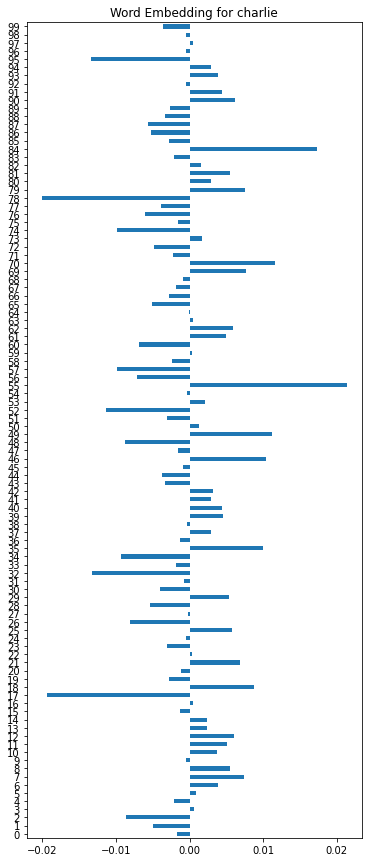

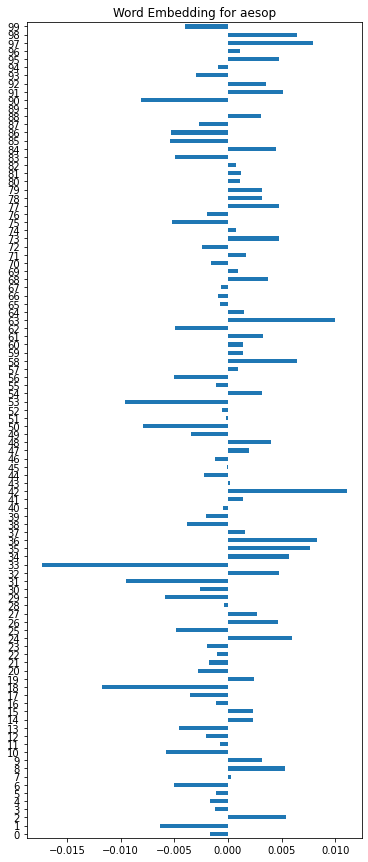

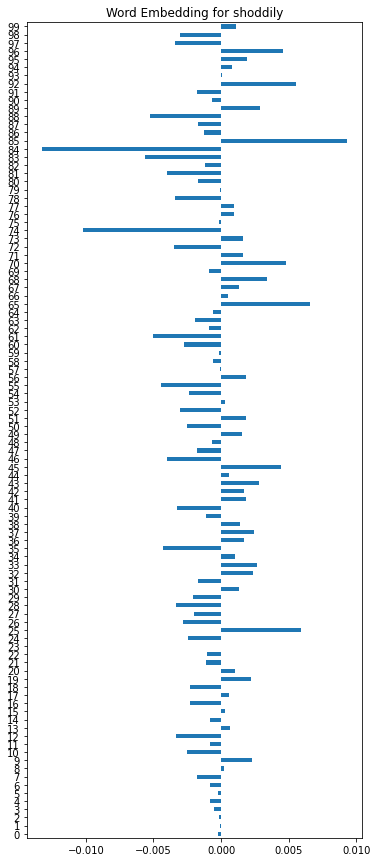

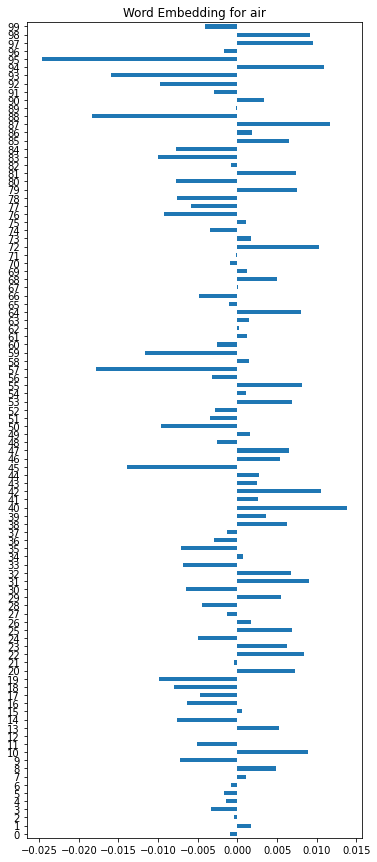

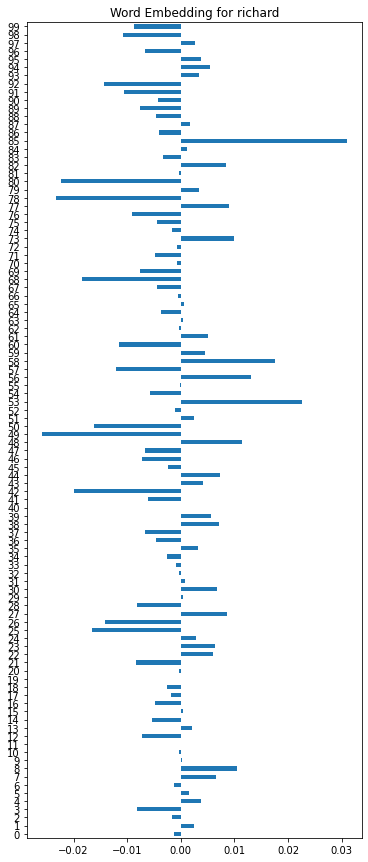

In [11]:
for i in range(5):
    plt.figure(figsize=(6,15))
    plt.title(f"Word Embedding for {embedding_matrix.index[i]}")
    embedding_matrix.iloc[i].plot(kind='barh')
    plt.show()

## Part (d):

    Then, please generate word embeddings of size 100 using Word2Vec.pynb (from the NLP lecture) on the same “200Reviews.csv” dataset. 
    
    Please show comparison on few examples to understand which method works better. Note your observations in your solution.

#### Word2Vec Implementation from the NLP Lecture

In [12]:
# Creating the model and setting values for the various parameters
# Using the same sentences that are input into the model to maintain comparability
num_features = 100  # Word vector dimensionality
min_word_count = 1 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 5        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers = num_workers,\
                          vector_size = num_features,\
                          min_count = min_word_count,\
                          window = context,
                          sample = downsampling)
print(model)
print("Done.")

Training model....
Word2Vec(vocab=6027, vector_size=100, alpha=0.025)
Done.


In [13]:
def cosine_similarity(word1, word2):
    """Calculates cosine similarity between two 2 word dimension features
    Args:
        word1 (list or pandas Series)
        word2 (list or pandas Series)

    Yields:
        cosine_similarity (0 < float < 1): Cosine similarity
    """
    if (np.linalg.norm(word1)*np.linalg.norm(word2)) == 0:
        cosine_similarity = -100
    else:
        cosine_similarity = np.dot(word1, word2) / (np.linalg.norm(word1)*np.linalg.norm(word2))
    return cosine_similarity


def most_similar(matrix, target_word, number=10):
    """Prints out the a number of most similar words based on cosine similarity
    Args:
        matrix (pandas DataFrame): Word embedding matrix
        word (str): Word vector to index the matrix
        number (int): How many words to return
    Yields:
        None 
    """
    print(f"Target word is [{target_word}]")
    features = np.array(matrix)
    word_features = np.array(matrix.loc[target_word])
    feature_cos_similarities = []
    for feature in features:
        feature_cos_similarities.append(cosine_similarity(feature, word_features))
    print("-"*56)
    
    similarity_rankings = np.argsort(feature_cos_similarities)
    for i in range(1, number+2):
        if matrix.index[similarity_rankings[-i]] != target_word:
            print(i-1, matrix.index[similarity_rankings[-i]], feature_cos_similarities[similarity_rankings[-i]])
    print("-"*56)
    
def doesnt_match(matrix, words):
    """Prints out the word that does not match in a list of words
    Args:
        matrix (pandas DataFrame): Word embedding matrix
        words (list of str): list of words to determine odd word
    Yields:
        None
    Remarks:
        Iterates through each focus word in words and calculates cosine_similarity between the focus word and the other words.
        The occurrence most dissimilar word from each focus word is added to a dict which tracks the number of occurences
        The word with the highest value in the dict is the word which is determined to be dissimilar from the most number of focus words.
    """
    oddwords = {}
    for focus_word in words:
        focus_word_features = np.array(matrix.loc[focus_word])
        similarity_list = []
        for compared_word in words:
            compared_word_features = np.array(matrix.loc[compared_word])
            similarity_list.append(cosine_similarity(compared_word_features, focus_word_features))
        odd_word = words[np.argsort(similarity_list)[0]]

        if odd_word in oddwords:
            oddwords[odd_word]+=1
        else:
            oddwords[odd_word]=1
    
    result = max(oddwords.keys(), key=oddwords.get)
    print(f"Odd Word: {result}")

In [14]:
# Words that will be tested on
similarwords = ["thrill", "horror", "comedy", "romance"]
doesntmatch = ["man woman dog child kitchen", 
               "cat dog lion tiger man"]

#### Evaluation based on Most Similar Words

In [15]:
for word in similarwords:
    print("Most Similar Words based on SVD Count Based Method")
    most_similar(embedding_matrix, word)
    print("Most Similar Words based on Word2Vec")
    print("Target Word:", word)
    count = 1
    for word2, score in model.wv.most_similar(word):
        print(count, word2, score)
        count += 1
    print("="*56)
    print()

Most Similar Words based on SVD Count Based Method
Target word is [thrill]
--------------------------------------------------------
0 overjoy 1.0
2 weep 0.9046623917319988
3 wiz 0.878417848436146
4 alternative 0.853546730780722
5 grass 0.853546730780722
6 fascinating 0.8470791202164661
7 ceremony 0.8435123498010818
8 caribbean 0.7972308062841066
9 starz 0.7943825761227766
10 worried 0.7907181622775727
--------------------------------------------------------
Most Similar Words based on Word2Vec
Target Word: thrill
1 fossilized 0.3384301960468292
2 cause 0.318146288394928
3 sitcom 0.3180883526802063
4 extremely 0.3119494915008545
5 miserable 0.3063412606716156
6 seek 0.30342936515808105
7 suggest 0.29555368423461914
8 coalition 0.292111873626709
9 tight 0.2920524775981903
10 thumb 0.2899966239929199

Most Similar Words based on SVD Count Based Method
Target word is [horror]
--------------------------------------------------------
1 edgar 0.6768376528294273
2 interview 0.6651176540690175


#### Evaluation based on Word that does not Match

In [17]:
for words in doesntmatch:
    print("List of Words:", words)
    print("SVD ", end = "")
    doesnt_match(embedding_matrix, words.split())
    print("Word2Vec Odd Word:", model.wv.doesnt_match(words.split()))
    print()

List of Words: man woman dog child kitchen
SVD Odd Word: kitchen
Word2Vec Odd Word: kitchen

List of Words: cat dog lion tiger man
SVD Odd Word: man
Word2Vec Odd Word: lion

